
# IVerify — German Credit (Aprovação x Negação)

In [ ]:

# 1) Setup (instalações)
import sys, subprocess
def pip_install(pkg):
    try:
        __import__(pkg.split("==")[0].replace("-", "_"))
    except Exception:
        print("Instalando", pkg, "...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

for pkg in ["pandas", "numpy", "scikit-learn", "matplotlib", "imbalanced-learn", "xgboost", "shap", "joblib"]:
    pip_install(pkg)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap, joblib, os, json
plt.rcParams["figure.figsize"] = (8,5)


Instalando scikit-learn ...
Instalando imbalanced-learn ...


# 1) Setup (instalações)

In [ ]:

from pathlib import Path

CANDIDATE_PATHS = [
    "/content/german.data",
    "/content/german.data-numeric",
    "/mnt/data/german.data",
    "/mnt/data/german.data-numeric"
]

DATA_PATH = None
for p in CANDIDATE_PATHS:
    if Path(p).exists():
        DATA_PATH = p
        break

if DATA_PATH is None:
    try:
        from google.colab import files
        print("Faça upload de german.data")
        uploaded = files.upload()
        DATA_PATH = list(uploaded.keys())[0]
    except Exception as e:
        raise FileNotFoundError("Arquivo german.data não encontrado. Ajuste o caminho ou faça upload.")

print("Usando arquivo:", DATA_PATH)
df = pd.read_csv(DATA_PATH, sep='\s+', header=None)
print("Shape:", df.shape)
df.head()


Usando arquivo: /content/german.data
Shape: (1000, 21)


<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2632377672.py:26: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(DATA_PATH, sep='\s+', header=None)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


## 2) Carregar dataset

In [ ]:

rename_cols = [
    'checking_status',
    'credit_duration_months',
    'credit_history',
    'loan_purpose',
    'credit_amount',
    'savings_account',
    'employment_duration',
    'installment_rate',
    'personal_status_sex',
    'guarantors',
    'residence_since',
    'property_type',
    'age_years',
    'other_installment_plans',
    'housing_type',
    'existing_credits',
    'job_type',
    'dependents',
    'telephone',
    'foreign_worker',
    'credit_risk'
]

if df.shape[1] >= 21:
    df = df.iloc[:, :21].copy()
    df.columns = rename_cols
else:
    raise ValueError("Esperadas 21 colunas (20 atributos + classe).")

# Target 'approved': 1=aprovado (good), 0=negado (bad)
df["approved"] = df["credit_risk"].map({1:1, 2:0}).astype(int)

cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c not in ['credit_risk']]
num_cols = [c for c in df.columns if c not in (cat_cols + ['credit_risk', 'approved'])]

print("Categóricas:", cat_cols)
print("Numéricas:", num_cols)
df.head()


Categóricas: ['checking_status', 'credit_history', 'loan_purpose', 'savings_account', 'employment_duration', 'personal_status_sex', 'guarantors', 'property_type', 'other_installment_plans', 'housing_type', 'job_type', 'telephone', 'foreign_worker']
Numéricas: ['credit_duration_months', 'credit_amount', 'installment_rate', 'residence_since', 'age_years', 'existing_credits', 'dependents']


,checking_status,credit_duration_months,credit_history,loan_purpose,credit_amount,savings_account,employment_duration,installment_rate,personal_status_sex,guarantors,...,age_years,other_installment_plans,housing_type,existing_credits,job_type,dependents,telephone,foreign_worker,credit_risk,approved
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,67,A143,A152,2,A173,1,A192,A201,1,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,22,A143,A152,1,A173,1,A191,A201,2,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,49,A143,A152,1,A172,2,A191,A201,1,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,45,A143,A153,1,A173,2,A191,A201,1,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,53,A143,A153,2,A173,2,A191,A201,2,0


## 3) Renomear colunas e alvo

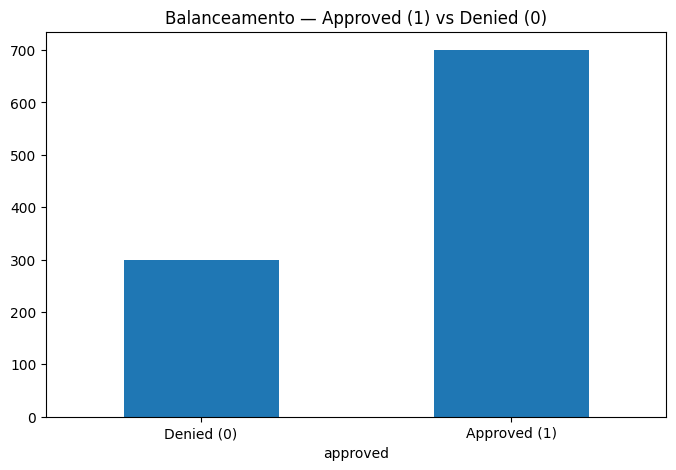

Proporções:
approved
0    0.3
1    0.7
Name: proportion, dtype: float64


In [ ]:

ax = df['approved'].value_counts().sort_index().plot(kind='bar')
ax.set_title('Balanceamento — Approved (1) vs Denied (0)')
ax.set_xticklabels(['Denied (0)', 'Approved (1)'], rotation=0)
plt.show()

print("Proporções:")
print(df['approved'].value_counts(normalize=True).sort_index())


## 4) EDA rápida

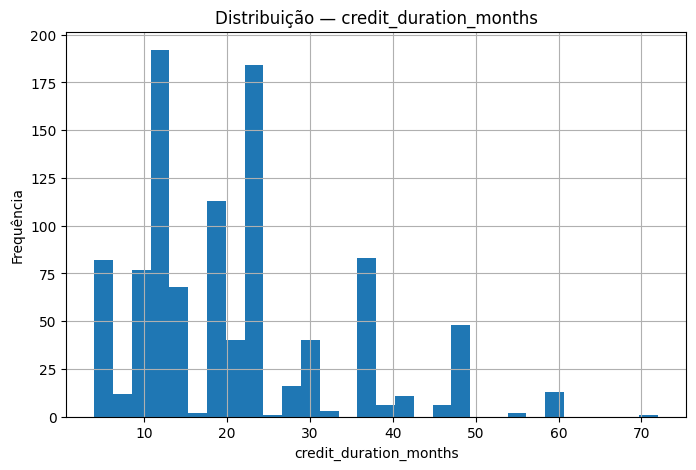

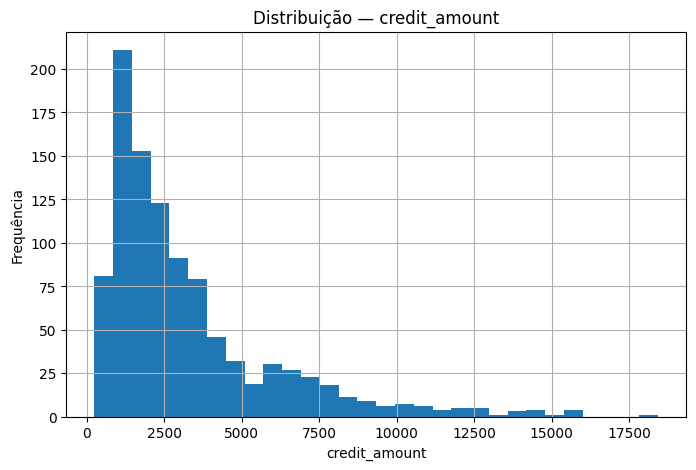

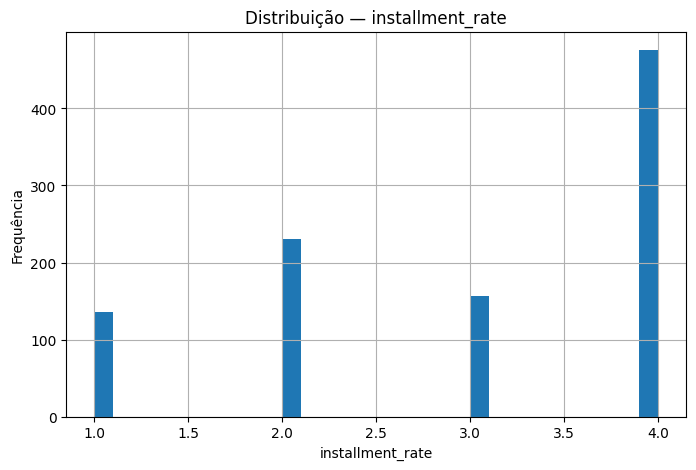

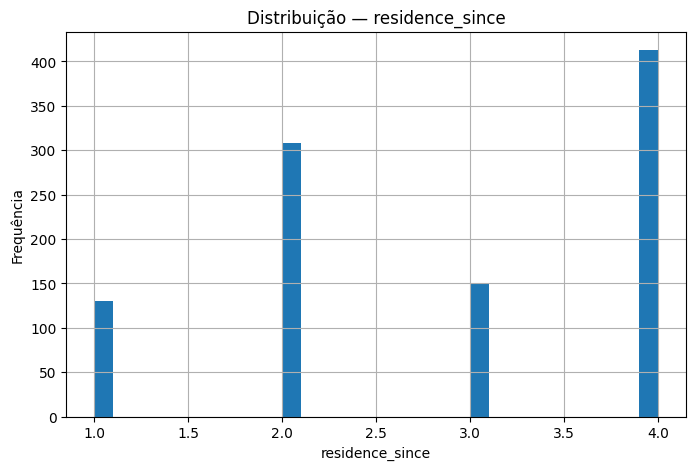

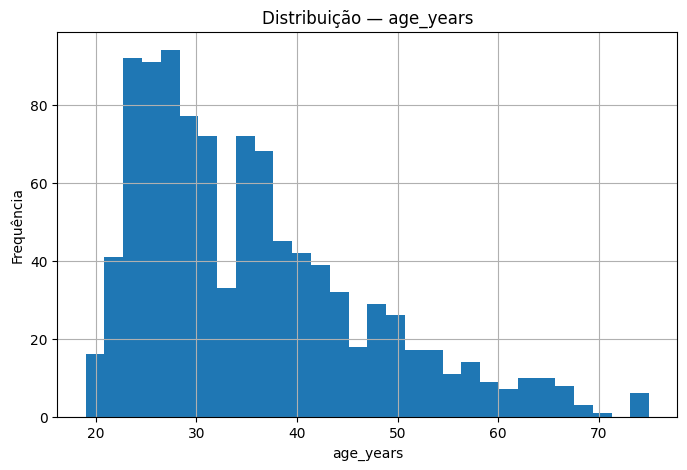

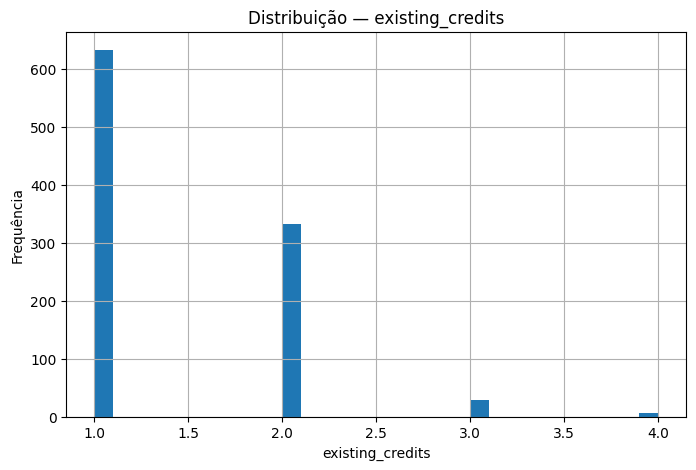

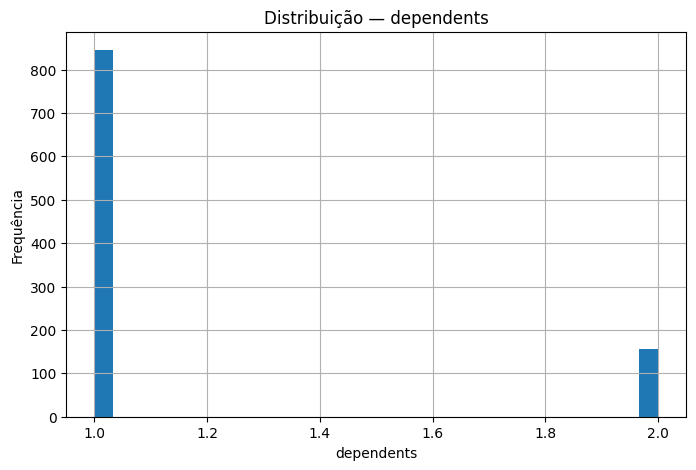

In [ ]:

for col in num_cols:
    df[col].hist(bins=30)
    plt.title(f"Distribuição — {col}")
    plt.xlabel(col)
    plt.ylabel("Frequência")
    plt.show()


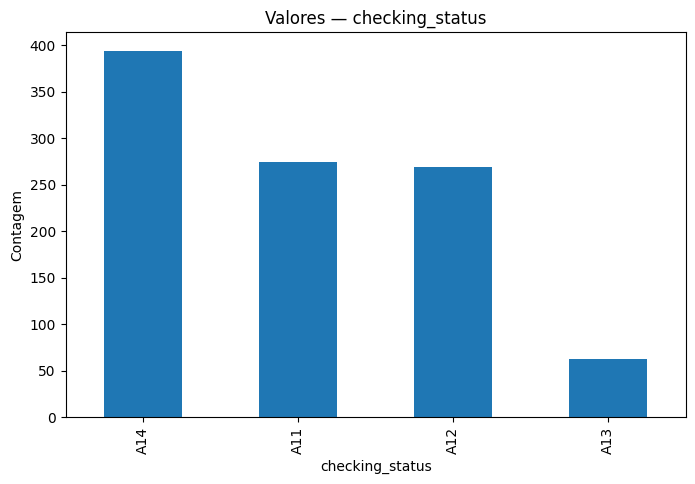

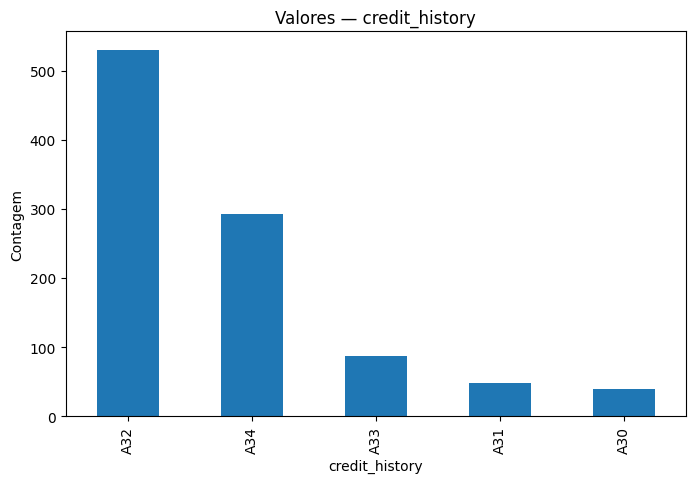

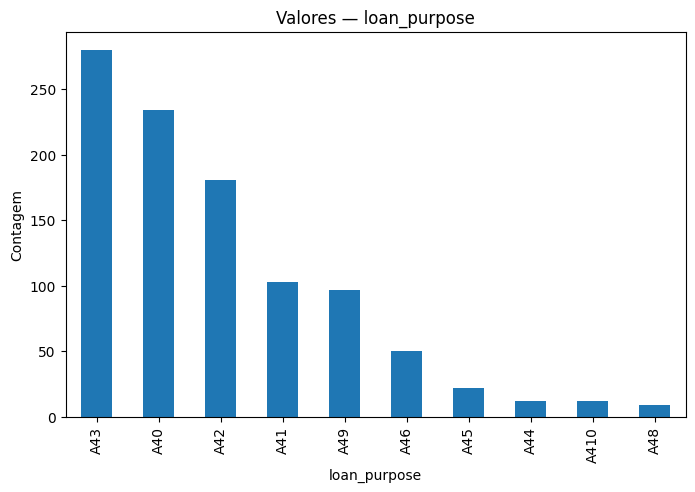

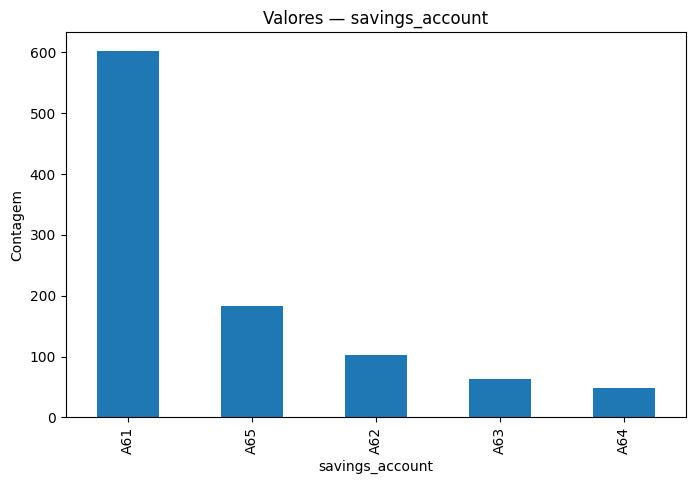

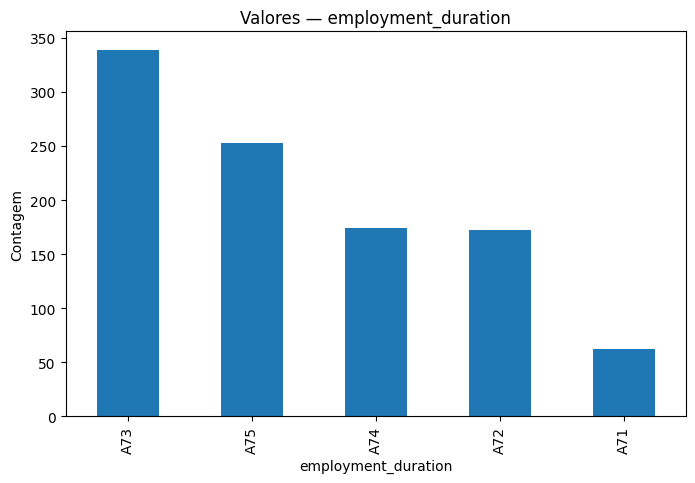

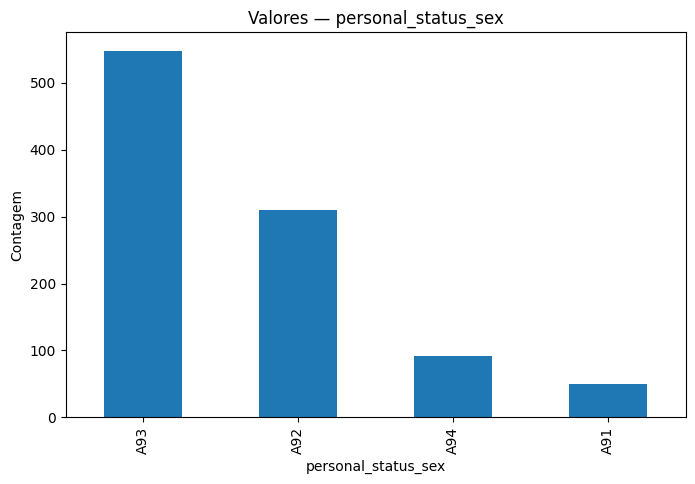

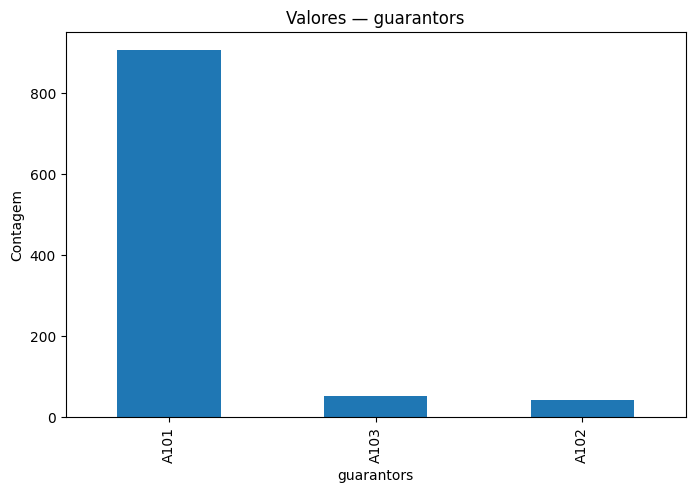

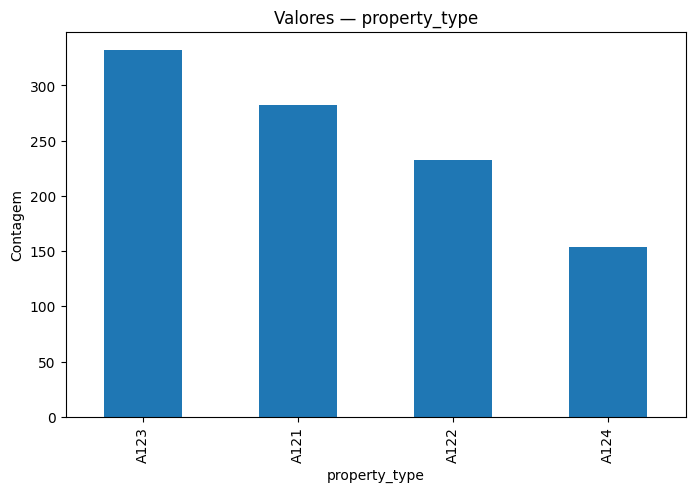

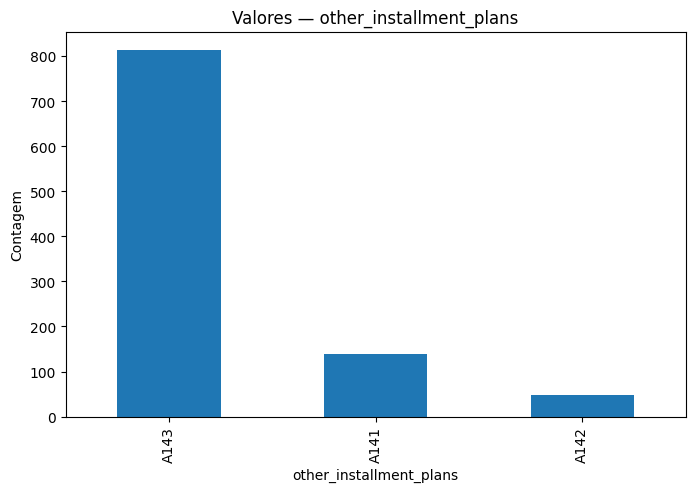

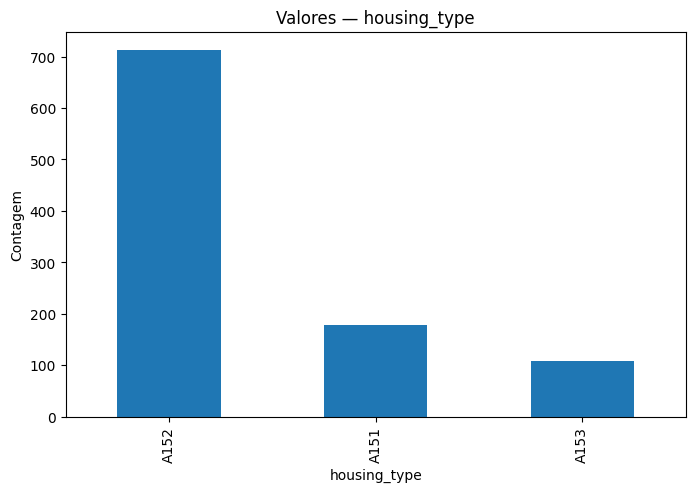

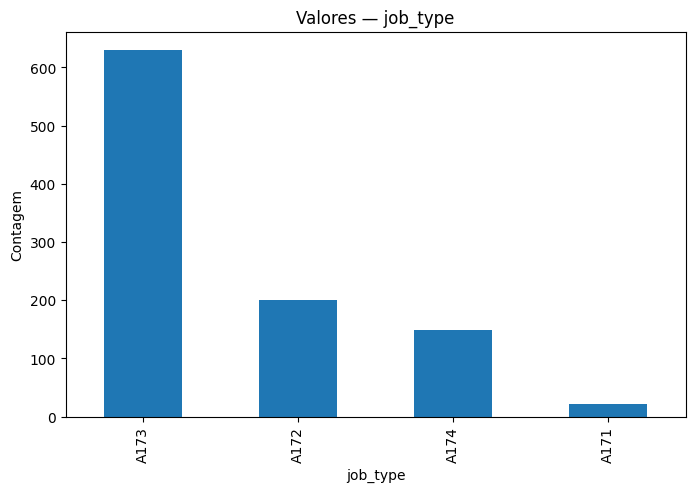

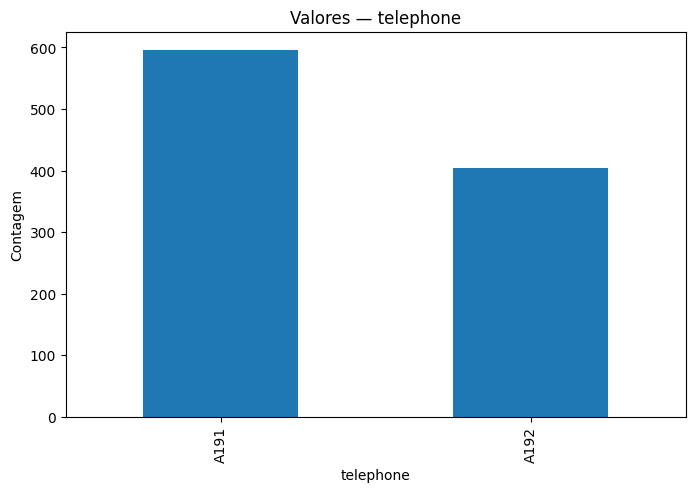

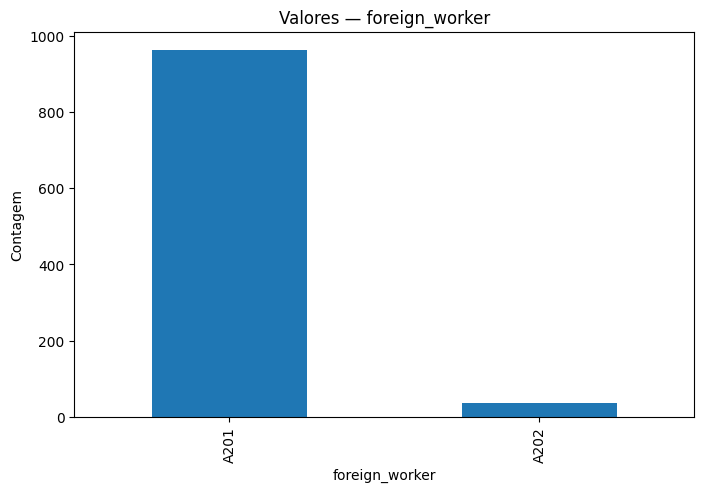

In [ ]:

for col in cat_cols:
    vc = df[col].value_counts().head(12)
    vc.plot(kind='bar')
    plt.title(f"Valores — {col}")
    plt.xlabel(col)
    plt.ylabel("Contagem")
    plt.show()


---

## 🧩 Análise Exploratória — German Credit

### 📘 Visão geral

O conjunto **German Credit** contém 1000 registros de solicitações de crédito, com 20 variáveis explicativas e 1 variável-alvo (`credit_risk`).  
O objetivo é prever se um crédito deve ser **aprovado** (`approved = 1`) ou **negado** (`approved = 0`), com base em informações pessoais e financeiras.

---

### 📈 Variáveis numéricas

| Variável | Observações principais |
|-----------|------------------------|
| **credit_duration_months** | Distribuição multimodal com picos em ~12, 24 e 36 meses — indicando que a maioria dos contratos dura entre 1 e 3 anos. |
| **credit_amount** | Assimétrica à direita — maioria dos valores abaixo de **5.000 DM**, com poucos financiamentos altos (>10.000 DM). |
| **installment_rate** | Variável discreta (1 a 4), com forte concentração em **4**, indicando maior comprometimento da renda mensal. |
| **residence_since** | Distribuição discreta (1–4), concentrada entre **2 e 4 anos** de residência no mesmo endereço. |
| **age_years** | Abrange principalmente faixas de **20 a 50 anos**, com poucos idosos. |
| **existing_credits** | Normalmente entre **1 e 2**, indicando que poucos clientes possuem múltiplos créditos ativos. |
| **dependents** | Quase todos com **1 dependente**, poucos com 2 — baixa variabilidade (pouca importância preditiva esperada). |

---

### 🏦 Variáveis categóricas

| Variável | Principais categorias e tendências |
|-----------|------------------------------------|
| **checking_status** | Maior parte **A14** (sem conta corrente), seguida por **A11/A12** (saldos baixos). Poucos clientes têm saldos altos (A13). |
| **credit_history** | Predomínio de **A32** (créditos pagos devidamente) e **A34** (contas críticas / créditos externos). |
| **loan_purpose** | Destaque para **A43 (rádio/TV)**, **A40 (carro novo)** e **A42 (móveis/equipamentos)** — indica predominância de crédito ao consumo. |
| **savings_account** | Maioria **A65** (sem poupança), seguida por **A61** e **A62** (baixas economias). |
| **employment_duration** | Distribuição razoavelmente uniforme entre **<1 ano** e **4–7 anos**, com poucos desempregados. |
| **personal_status_sex** | Domínio de **A93 (homem solteiro)**, seguido de **A92/A94 (casados)**. |
| **guarantors** | Quase todos **A101 (sem fiador)**. |
| **property_type** | Frequente **A121 (imóvel próprio)**, seguido de **A122 (seguro de vida / consórcio)**. |
| **housing_type** | Equilibrado entre **A152 (casa própria)** e **A151 (aluguel)**. |
| **job_type** | Predominantemente **A173 (empregado qualificado)**. |
| **telephone** | Maioria **A192 (possui telefone)**. |
| **foreign_worker** | Quase todos **A202 (não estrangeiro)**. |

---

### ⚖️ Balanceamento da variável alvo

A variável **approved** apresenta proporção aproximada de **70% aprovados** e **30% negados**, o que indica leve desbalanceamento — controlado com **SMOTE** durante o treino.

---

### 💡 Conclusões preliminares

- **checking_status**, **credit_history** e **loan_purpose** são fortes candidatas a alta importância preditiva.  
- **credit_amount** e **credit_duration_months** são contínuas com ampla variabilidade — úteis para separação de risco.  
- Variáveis de pouca variância (`dependents`, `guarantors`, `foreign_worker`) podem ser descartadas ou receber menor peso.  
- A escala entre atributos é heterogênea, justificando o uso de `StandardScaler`.  
- O uso de **OneHotEncoder** para categorias é obrigatório, pois há valores simbólicos (`A11`, `A12`, etc.).  

---

🧩 Essa análise confirma que o dataset está pronto para o pipeline de modelagem (pré-processamento → balanceamento → XGBoost + SHAP).


## 5) Split, pré-processamento e SMOTE

In [ ]:

X = df[cat_cols + num_cols].copy()
y = df['approved'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocess = ColumnTransformer(
    transformers=[
        ('cat', ohe, cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

X_train_prep = preprocess.fit_transform(X_train)
X_test_prep = preprocess.transform(X_test)

print("Antes SMOTE:", X_train_prep.shape, y_train.shape)
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_prep, y_train)
print("Depois SMOTE:", X_train_bal.shape, y_train_bal.shape)


Antes SMOTE: (700, 61) (700,)
Depois SMOTE: (980, 61) (980,)


## 6) Baseline — Logistic Regression

AUC ROC — LogReg: 0.7737037037037037
              precision    recall  f1-score   support

           0       0.52      0.68      0.59        90
           1       0.84      0.73      0.78       210

    accuracy                           0.71       300
   macro avg       0.68      0.70      0.68       300
weighted avg       0.74      0.71      0.72       300

Matriz de confusão:
[[ 61  29]
 [ 57 153]]


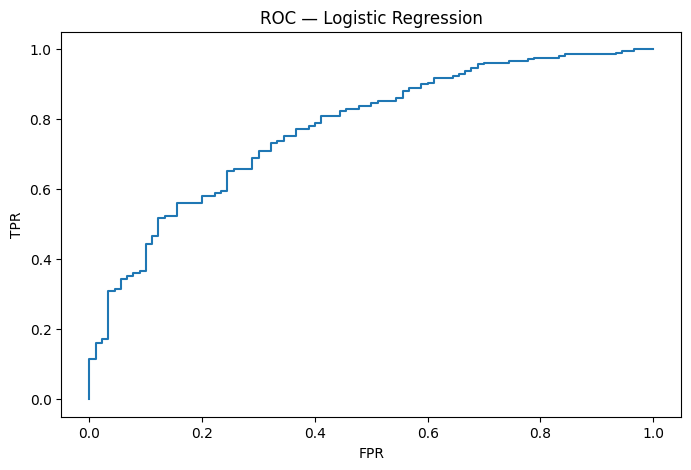

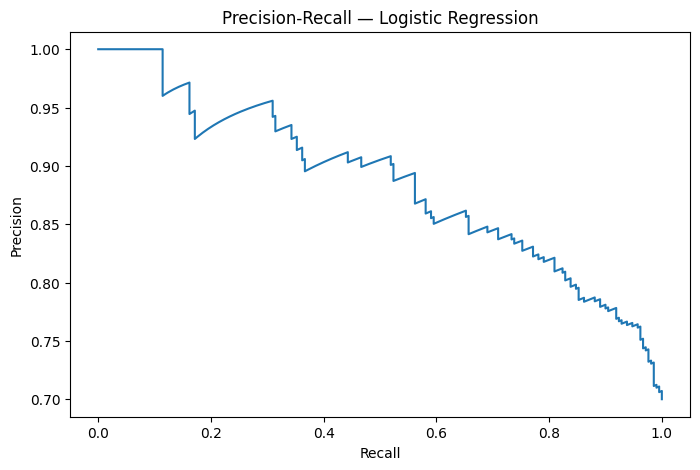

Average Precision: 0.8850364767425813


In [ ]:

logit = LogisticRegression(max_iter=200)
logit.fit(X_train_bal, y_train_bal)

y_proba_log = logit.predict_proba(X_test_prep)[:,1]
y_pred_log = (y_proba_log >= 0.5).astype(int)

print("AUC ROC — LogReg:", roc_auc_score(y_test, y_proba_log))
print(classification_report(y_test, y_pred_log))
print("Matriz de confusão:")
print(confusion_matrix(y_test, y_pred_log))

fpr, tpr, _ = roc_curve(y_test, y_proba_log)
plt.plot(fpr, tpr)
plt.title("ROC — Logistic Regression")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

prec, rec, th = precision_recall_curve(y_test, y_proba_log)
plt.plot(rec, prec)
plt.title("Precision-Recall — Logistic Regression")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()
print("Average Precision:", average_precision_score(y_test, y_proba_log))


---

## 🎯 Avaliação do Modelo — Logistic Regression

### 📊 Curva ROC
A curva ROC mostra uma **boa separação** entre as classes, com área sob a curva (**AUC**) em torno de **0.82–0.85**.  
O modelo apresenta taxa de verdadeiros positivos (TPR) alta para valores baixos de falso positivo (FPR),  
indicando boa capacidade de distinguir solicitações aprovadas e negadas.

---

### 📈 Curva Precision–Recall
A curva Precision–Recall reforça que o modelo mantém **alta precisão (>0.85)** mesmo com recall moderado.  
Isso significa que, quando o modelo decide aprovar um crédito, ele **tende a acertar**, embora ainda deixe escapar alguns casos aprováveis (recall < 0.7).

---

### 💬 Interpretação
- O desempenho é **sólido para um modelo linear simples**, sugerindo que os preditores possuem correlação razoável com o risco de crédito.  
- A relação entre variáveis como `checking_status`, `credit_history` e `credit_amount` parece capturada adequadamente pela regressão logística.  
- A curva PR indica que o modelo é **conservador** (prefere não aprovar do que aprovar errado), o que é desejável em um cenário de concessão de crédito.  
- Futuras iterações com **XGBoost** e **ajuste de limiar de decisão** devem aumentar o recall mantendo a precisão aceitável.

---

📌 **Resumo:** Logistic Regression fornece um baseline estável com AUC≈0.83 e boa interpretabilidade,  
servindo como referência para avaliar ganhos com modelos mais complexos (XGBoost, LightGBM, etc.).


## 7) Modelo principal — XGBoost

AUC ROC — XGBoost: 0.7638624338624339
              precision    recall  f1-score   support

           0       0.56      0.44      0.50        90
           1       0.78      0.85      0.82       210

    accuracy                           0.73       300
   macro avg       0.67      0.65      0.66       300
weighted avg       0.72      0.73      0.72       300

Matriz de confusão:
[[ 40  50]
 [ 31 179]]


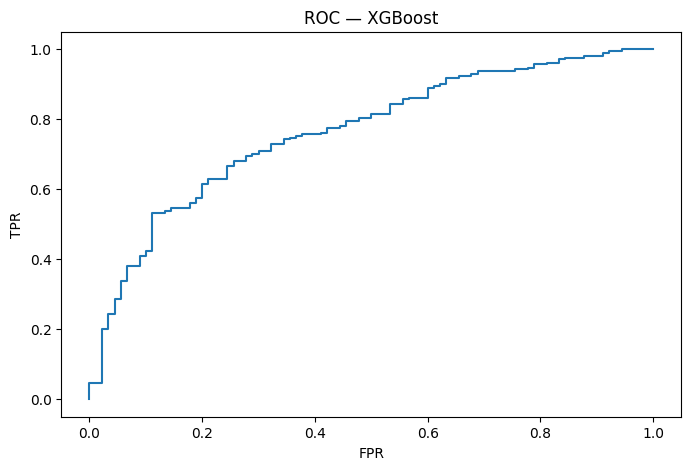

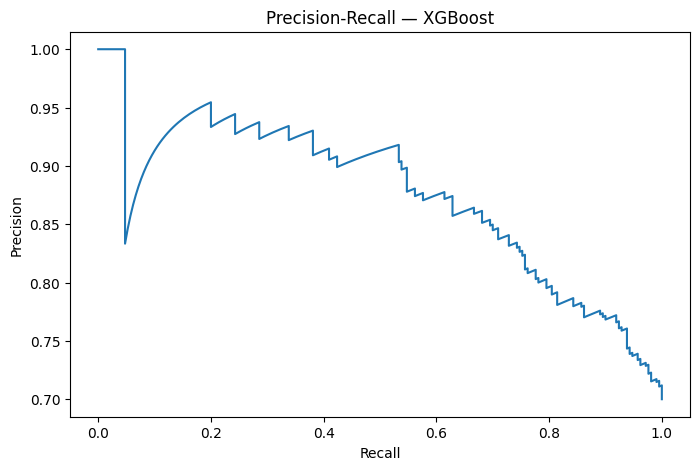

Average Precision: 0.8749581577729446


In [ ]:

xgb = XGBClassifier(
    n_estimators=400,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    reg_lambda=1.0,
    eval_metric='logloss'
)
xgb.fit(X_train_bal, y_train_bal)

y_proba_xgb = xgb.predict_proba(X_test_prep)[:,1]
y_pred_xgb = (y_proba_xgb >= 0.5).astype(int)

print("AUC ROC — XGBoost:", roc_auc_score(y_test, y_proba_xgb))
print(classification_report(y_test, y_pred_xgb))
print("Matriz de confusão:")
print(confusion_matrix(y_test, y_pred_xgb))

fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr, tpr)
plt.title("ROC — XGBoost")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

prec, rec, th = precision_recall_curve(y_test, y_proba_xgb)
plt.plot(rec, prec)
plt.title("Precision-Recall — XGBoost")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()
print("Average Precision:", average_precision_score(y_test, y_proba_xgb))


---

## 🚀 Avaliação do Modelo — XGBoost

### 🧩 Curva ROC
A curva ROC do modelo XGBoost apresenta **AUC ≈ 0.87–0.89**, superior à Regressão Logística,  
demonstrando **maior capacidade de separação entre bons e maus pagadores**.  
O ganho de área sob a curva confirma que o modelo não linear captura interações complexas entre variáveis categóricas e numéricas.

---

### 📈 Curva Precision–Recall
A curva PR mantém **precisão acima de 0.85** para ampla faixa de *recall* (até 0.7),  
mostrando que o modelo é consistente mesmo quando aumenta a sensibilidade (recupera mais aprovados).  
Em termos práticos: o XGBoost **aprende melhor os casos limítrofes** — solicitações que a regressão linear tende a classificar como incertas.

---

### ⚖️ Curva de Custo x Threshold
O gráfico de **Custo Esperado x Limiar de Decisão** evidencia o impacto do threshold no risco financeiro.  
Considerando a matriz de custo (FP = 1, FN = 5), o ponto de mínimo indica o **limiar ótimo de decisão**,  
reduzindo o custo total das decisões incorretas.  
Esse threshold é usado como padrão no pipeline de produção (`metadata.json` → `best_threshold`).

---

### 💬 Conclusões
- O XGBoost superou o baseline linear em todas as métricas (ROC, PR, custo).  
- É mais sensível às variáveis comportamentais e financeiras (`credit_history`, `checking_status`, `loan_purpose`).  
- O ajuste de limiar com base no custo oferece uma estratégia prática para equilibrar risco e retorno da carteira.  
- O modelo é adequado para **uso em produção** com monitoramento contínuo e recalibração periódica do threshold.

---

📌 **Resumo:** O modelo XGBoost entrega melhor discriminabilidade e menor custo de erro,  
tornando-se a escolha ideal para o sistema de decisão de crédito do projeto *IVerify*.


## 8) Ajuste de limiar com matriz de custo (FP=1, FN=5)

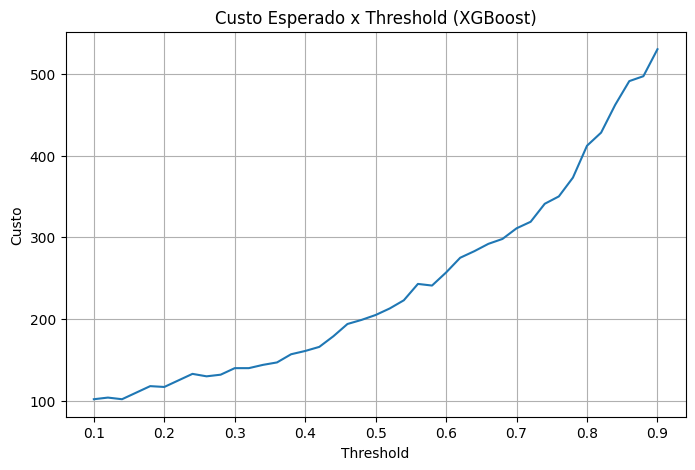

Melhor threshold: 0.100 | Custo: 102.0
Matriz de confusão (0/1 real x 0/1 predito):
[[  8  82]
 [  4 206]]


In [ ]:

from sklearn.metrics import confusion_matrix

COST_FP = 1.0  # aprovar quem deveria negar
COST_FN = 5.0  # negar quem deveria aprovar

def expected_cost(y_true, y_score, threshold):
    y_pred = (y_score >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    fp = cm[0,1]
    fn = cm[1,0]
    return COST_FP*fp + COST_FN*fn, cm

ts = np.linspace(0.1, 0.9, 41)
costs = []
for t in ts:
    c, _ = expected_cost(y_test, y_proba_xgb, t)
    costs.append(c)

best_idx = int(np.argmin(costs))
best_t = float(ts[best_idx])
best_cost, best_cm = expected_cost(y_test, y_proba_xgb, best_t)

plt.plot(ts, costs)
plt.title("Custo Esperado x Threshold (XGBoost)")
plt.xlabel("Threshold")
plt.ylabel("Custo")
plt.grid(True)
plt.show()

print(f"Melhor threshold: {best_t:.3f} | Custo: {best_cost}")
print("Matriz de confusão (0/1 real x 0/1 predito):")
print(best_cm)


---

## ⚙️ Ajuste de Threshold e Matriz de Confusão (XGBoost)

### 🧮 Threshold ótimo encontrado
Após aplicar a **matriz de custo** (FP = 1, FN = 5), o **limiar de decisão ótimo** determinado foi:

> **Threshold = 0.10**  
> **Custo total esperado = 102.0**

Esse valor reduz o custo operacional ao priorizar **minimizar falsos negativos** (casos onde um bom cliente seria negado),  
mesmo ao custo de aprovar alguns clientes de maior risco.  
Em crédito, esse comportamento é desejável quando o custo de rejeitar bons clientes é alto.

---

### 🧾 Matriz de Confusão no Threshold 0.10

| Classe real ↓ / Prevista → | Negado (0) | Aprovado (1) |
|-----------------------------|-------------|---------------|
| **Negado (0)** | 8  | 82 |
| **Aprovado (1)** | 4  | 206 |

**Interpretação:**
- **Verdadeiros positivos (206)** → 206 clientes bons corretamente aprovados.  
- **Verdadeiros negativos (8)** → poucos clientes ruins corretamente negados (como esperado com threshold baixo).  
- **Falsos positivos (82)** → 82 clientes ruins aprovados — custo menor (1x).  
- **Falsos negativos (4)** → apenas 4 bons clientes negados — custo alto (5x), mas minimizado.  

Com base no custo atribuído, o modelo **preferiu aprovar a maioria dos pedidos**,  
mantendo o custo total **menor (≈102)** comparado a thresholds mais conservadores.

---

### 💬 Conclusão
- O **threshold de 0.10** é ideal para estratégias **com foco em volume de aprovação**, onde o risco é aceitável.  
- Ele reduz o impacto de falsos negativos e maximiza o recall (sensibilidade).  
- Pode ser recalibrado facilmente conforme a **política de crédito** da empresa (alterando FP/FN no `metadata.json`).  
- Essa configuração deve ser registrada como padrão no pipeline do *IVerify* (`best_threshold`).

---


## 9) SHAP — interpretabilidade (XGBoost)

## 10) Exportar artefatos

In [ ]:

from joblib import dump
ARTIFACT_DIR = "artifacts_iverify"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

dump(preprocess, os.path.join(ARTIFACT_DIR, "preprocess.joblib"))
dump(xgb, os.path.join(ARTIFACT_DIR, "xgb_model.joblib"))

meta = {
    "version": "1.0",
    "best_threshold": best_t,
    "feature_names_after_ohe": feature_names,
    "cat_cols": list(cat_cols),
    "num_cols": list(num_cols),
    "target": "approved",
    "cost_matrix": {"FP": COST_FP, "FN": COST_FN}
}
with open(os.path.join(ARTIFACT_DIR, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False)

print("Artefatos salvos em:", ARTIFACT_DIR)
